# Run a trained policy

This notebook will provide examples on how to run a trained policy and visualize the rollout.

In [3]:
import isaacgym
import isaacgymenvs
from hydra import compose, initialize_config_dir
from omegaconf import OmegaConf
from pathlib import Path

plt_root = Path("../../../policy_learning_toolkit/").expanduser()
igenvs_root = Path("~/diff_manip/external/IsaacGymEnvs").expanduser()

import argparse
import json
import h5py
import yaml
import isaacgym
import imageio
import numpy as np
import os
from copy import deepcopy

import torch

import robomimic
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
from robomimic.envs.env_base import EnvBase
from robomimic.algo import RolloutPolicy

# from stable_baselines3.buffers.


import urllib.request


In [2]:
import sys, os

sys.path.append(os.path.expanduser("../"))
from env_bidex import create_bidex_env
env = create_bidex_env("ShadowHandScissors", "ppo", False)

Importing module 'gym_38' (/home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


PyTorch version 2.3.0+cu121
Device count 1
/home/krishnans/carbgym/python/isaacgym/_bindings/src/gymtorch


Using /home/krishnans/.cache/torch_extensions/py38_cu121 as PyTorch extensions root...
Emitting ninja build file /home/krishnans/.cache/torch_extensions/py38_cu121/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF gymtorch.o.d -DTORCH_EXTENSION_NAME=gymtorch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torch/include -isystem /home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torch/include/TH -isystem /home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torch/include/THC -isystem /home/krishnans/miniconda3/envs/robomimic/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -DTORCH_MAJOR=2 -DTORCH_MINOR=3 -c /home/krishnans/carbgym/python/isaacgym/_bindings/src/gymtorch/gymtorch.cpp -o gymtorch.o 
FAILED: gymtorch.o 
c++ -MMD -MF gymtorch.o.d -DTORCH_EXTENSION_NAME=gymtorch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDL

RuntimeError: Error building extension 'gymtorch'

In [3]:
ls /home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/**/models/

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240424142605/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240424145709/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240424151320/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240424151417/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502032851/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502033007/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502033228/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502033334/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502033540/models/:

/home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/20240502033612/models/:
model_epoch_100.pth  model_epoch_200.pth
model_epoch_150.pth  model_epoch_50.pth


In [4]:

ckpt_path = "/home/krishnans/ngc/robomimic/act_trained_models/ACT++_Bidex_Switch/20240513051804/models/model_epoch_800.pth"

policy, ckpt_dict = FileUtils.policy_from_checkpoint(
    ckpt_path=ckpt_path, 
    device='cuda:0', 
    verbose=True
)

============= Loaded Config =============
{
    "algo_name": "act",
    "experiment": {
        "name": "ACT++_Bidex_Switch",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": true,
            "wandb_proj_name": "robomimic"
        },
        "mse": {
            "enabled": false,
            "every_n_epochs": 50,
            "on_save_ckpt": true,
            "num_samples": 20,
            "visualize": true
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 40,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 500,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
 

/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Use VQ: True, 512, 64
number of parameters: 117.86M
============= Loaded Policy =============
ACT (
  ModuleDict(
    (policy): DETRVAE(
      (transformer): Transformer(
        (encoder): TransformerEncoder(
          (layers): ModuleList(
            (0-3): 4 x TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
              )
              (linear1): Linear(in_features=512, out_features=3200, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (linear2): Linear(in_features=3200, out_features=512, bias=True)
              (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (dropout1): Dropout(p=0.1, inplace=False)
              (dropout2): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (decoder): Transfo

In [6]:
config = yaml.safe_load(open("/home/krishnans/ngc/robomimic/act_trained_models/ACT++_Bidex_Switch/20240513051804/config.json"))

In [7]:
config

{'algo_name': 'act',
 'experiment': {'name': 'ACT++_Bidex_Switch',
  'validate': False,
  'logging': {'terminal_output_to_txt': True,
   'log_tb': True,
   'log_wandb': True,
   'wandb_proj_name': 'robomimic'},
  'mse': {'enabled': False,
   'every_n_epochs': 50,
   'on_save_ckpt': True,
   'num_samples': 20,
   'visualize': True},
  'save': {'enabled': True,
   'every_n_seconds': None,
   'every_n_epochs': 40,
   'epochs': [],
   'on_best_validation': False,
   'on_best_rollout_return': False,
   'on_best_rollout_success_rate': True},
  'epoch_every_n_steps': 500,
  'validation_epoch_every_n_steps': 10,
  'env': None,
  'additional_envs': None,
  'render': False,
  'render_video': True,
  'keep_all_videos': False,
  'video_skip': 5,
  'rollout': {'enabled': False,
   'n': 50,
   'horizon': 400,
   'rate': 40,
   'warmstart': 0,
   'terminate_on_success': True,
   'batched': False,
   'num_batch_envs': 5},
  'env_meta_update_dict': {},
  'ckpt_path': None},
 'train': {'data': [{'path':

In [10]:
hdf5_path = "/home/krishnans/ngc/bidex_datasets"

In [11]:
ls {hdf5_path}/**/*.hdf5

/home/krishnans/ngc/bidex_datasets/scissors/rollouts_1000.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_1000_no_img.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_100.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_500.hdf5
/home/krishnans/ngc/bidex_datasets/switch/rollouts_100.hdf5
/home/krishnans/ngc/bidex_datasets/switch/rollouts_500.hdf5


In [12]:
import h5py
hdf5_path = f"{hdf5_path}/switch/rollouts_100.hdf5"

data = h5py.File(hdf5_path, "r")
cam_obs_keys = list(filter(lambda x: "camera" in x, list(data["data/demo_0/obs"].keys())))

In [13]:

cam_obs_key = 'fixed_camera'
d_idx = 0
data_dict = {'obs': {cam_obs_key: data[f'data/demo_{d_idx}/obs/fixed_camera'][:]},
             'actions': data[f'data/demo_{d_idx}/actions'][:]}
tensor_data_dict = TensorUtils.to_device(TensorUtils.to_tensor(data_dict), policy.policy.device)
input_dict = policy.policy.process_batch_for_training(tensor_data_dict)
input_dict = policy.policy.postprocess_batch_for_training(input_dict, obs_normalization_stats=None)


import matplotlib.pyplot as plt

obs_encoder = policy.policy.nets['policy'].nets['encoder'].nets['obs']
obs_randomizer = obs_encoder.obs_randomizers[cam_obs_key]
obs_net = obs_encoder.obs_nets[cam_obs_key] # Spatial Softmax
backbone = obs_net.nets[:1]

# obs_processed = obs_randomizer[0].forward_in(tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)).requires_grad_(True)
obs_processed = tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2).requires_grad_(True)

KeyError: 'pad_mask'

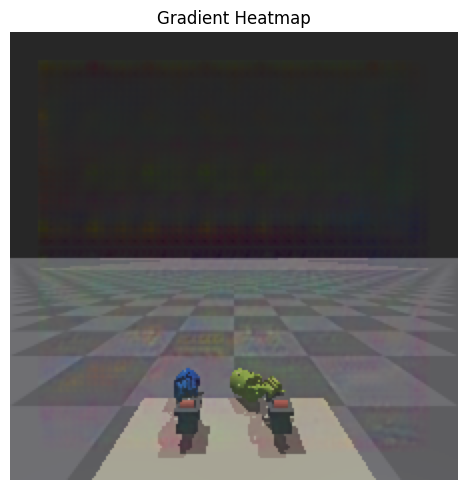

In [21]:
import matplotlib.pyplot as plt

cam_obs_key = 'fixed_camera'
obs_encoder = policy.policy.nets['policy'].nets['encoder'].nets['obs']
obs_randomizer = obs_encoder.obs_randomizers[cam_obs_key]
obs_net = obs_encoder.obs_nets[cam_obs_key] # Spatial Softmax
backbone = obs_net.nets[:1]

# obs_processed = obs_randomizer[0].forward_in(tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)).requires_grad_(True)
obs_processed = tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2).requires_grad_(True)

obs_backbone_feat = backbone(obs_processed).sum().backward()
# weights = obs_net.nets[1](obs_backbone_feat).mean().backward()

# indices = weights.argmax(dim=-1).to(torch.int64).detach()

# num_keypoints = indices.shape[-1] // 2
# x_indices = indices[..., :num_keypoints] 
# y_indices = indices[..., num_keypoints:]

# max_features = obs_backbone_feat[torch.arange(obs_backbone_feat.shape[0]).unsqueeze(-1), 
#                                  y_indices, 
#                                  x_indices]
# sum_max_features = max_features.sum(dim=1)

# sum_max_features.sum().backward()

# Normalize the gradients for visualization
gradients = obs_processed.grad
gradients = gradients - gradients.min() 
gradients /= torch.nn.functional.softmax(gradients, dim=1)



idx = 120
img = obs_processed[idx].permute(1, 2, 0).detach().cpu().numpy()

# Upsample the gradients to match the original image size
# gradients_upsampled = torch.nn.functional.interpolate(gradients, size=img.shape, mode='bilinear', align_corners=False)
gradients_upsampled = gradients.cpu().numpy()[idx].transpose(1, 2, 0)

# Convert to numpy and transpose (H, W, C)
# gradients_upsampled = gradients_upsampled.cpu().numpy()[0].transpose(1, 2, 0)

# Plot the gradient heatmap on top of the original image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img)  
ax.imshow(gradients_upsampled, cmap='jet', alpha=0.5)
ax.set_title("Gradient Heatmap")
ax.axis('off')

plt.tight_layout()
plt.show()


In [201]:
gradients_upsampled.shape

(200, 200, 3)

In [151]:
gradients.shape, img.shape

(torch.Size([148, 3, 48, 48]), (48, 48, 3))

In [145]:
img.shape, gradients.shape, gradients_upsampled.shape

((48, 48, 3), torch.Size([148, 3, 48, 48]), (48, 3, 3))

In [124]:
weights.shape

torch.Size([148, 64])

In [16]:
import matplotlib.pyplot as plt

cam_obs_key = 'fixed_camera'
obs_encoder = policy.policy.nets['policy'].nets['encoder'].nets['obs']
obs_randomizer = obs_encoder.obs_randomizers[cam_obs_key]
obs_net = obs_encoder.obs_nets[cam_obs_key]

obs_processed = obs_randomizer[0].forward_in(tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)).requires_grad_(True)

weights = obs_net(obs_processed)
# Compute gradients
obs_processed.retain_grad()
# Get the maximum activation for each image
max_activation = weights.max(dim=-1)[0].max(dim=-1)[0]  # Reduce to get the maximum value for each image

# Sum the maximum activations across all images
sum_top_activations = max_activation.sum()
sum_top_activations.backward()

print(f"Sum of top feature activations across all images: {sum_top_activations:.4f}")


# Get the gradients
gradients = obs_processed.grad

# Normalize the gradients for visualization
gradients = gradients - gradients.min() 
gradients /= gradients.max()

# Assuming img is the original input image (C, H, W)
# img = tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)[0]
img = obs_processed[0].permute(1, 2, 0).detach().cpu().numpy()


# Upsample the gradients to match the original image size
gradients_upsampled = torch.nn.functional.interpolate(gradients, size=img.shape[1:], mode='bilinear', align_corners=False)

# Convert to numpy and transpose (H, W, C)
gradients_upsampled = gradients_upsampled.cpu().numpy()[0].transpose(1, 2, 0)

# Plot the original image and the gradient heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)  
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(gradients_upsampled, cmap='jet')
ax2.set_title("Gradient Heatmap")  
ax2.axis('off')

plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'forward_in'

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4824, 0.4824, 0.4824,  ..., 0.4980, 0.4980, 0.4980],
          [0.4235, 0.4235, 0.4235,  ..., 0.5608, 0.5608, 0.5608],
          [0.4235, 0.4235, 0.4235,  ..., 0.5608, 0.5608, 0.5608]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4824, 0.4824, 0.4824,  ..., 0.4980, 0.4980, 0.4980],
          [0.4235, 0.4235, 0.4235,  ..., 0.5608, 0.5608, 0.5608],
          [0.4235, 0.4235, 0.4235,  ..., 0.5608, 0.5608, 0.5608]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [111]:
max_activation = weights.max(dim=-1)[0].max(dim=-1)[0]  # Reduce to get the maximum indices
indices = np.unravel_index(max_activation.argmax(), weights.shape[2:])
y, x = indices  # Coordinates in the feature map

plt.imshow(img.permute(1, 2, 0))  # Assuming img is (C, H, W)
plt.scatter([x * (img.shape[2] / feature_map.shape[3])], [y * (img.shape[1] / feature_map.shape[2])], color='red')  # Scale up to image size
plt.show()


torch.Size([148, 64])

### Download policy checkpoint
First, let's try downloading a pretrained model from our model zoo.

In [2]:
# Get pretrained checkpooint from the model zoo

ckpt_path = "lift_ph_low_dim_epoch_1000_succ_100.pth"
# Lift (Proficient Human)
urllib.request.urlretrieve(
    "http://downloads.cs.stanford.edu/downloads/rt_benchmark/model_zoo/lift/bc_rnn/lift_ph_low_dim_epoch_1000_succ_100.pth",
    filename=ckpt_path
)

assert os.path.exists(ckpt_path)

In [3]:
ckpt_path = "../../bc_trained_models/test/20240403143734/models/model_epoch_2000.pth"

### Loading trained policy
We have a convenient function called `policy_from_checkpoint` that takes care of building the correct model from the checkpoint and load the trained weights. Of course you could also load the checkpoint manually.

In [4]:
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=True)

============= Loaded Config =============
{
    "algo_name": "bc",
    "experiment": {
        "name": "test",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": false,
            "wandb_proj_name": "debug"
        },
        "mse": {
            "enabled": false,
            "every_n_epochs": 50,
            "on_save_ckpt": true,
            "num_samples": 20,
            "visualize": true
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_v

/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Creating rollout envionment
The policy checkpoint also contains sufficient information to recreate the environment that it's trained with. Again, you may manually create the environment.

In [5]:
# create environment from saved checkpoint
env, _ = FileUtils.env_from_checkpoint(
    ckpt_dict=ckpt_dict, 
    render=False, # we won't do on-screen rendering in the notebook
    render_offscreen=True, # render to RGB images for video
    verbose=True,
)

KeyError: 'type'

In [6]:
config_dir = str(igenvs_root / "isaacgymenvs" / "cfg")
overrides = ["task=ArticulateTaskSprayScissorsCamera", "test=true", "num_envs=100", 
             "train=ArticulateTaskPPONew"]
with initialize_config_dir(config_dir=config_dir, version_base="1.3"):
    cfg_expert = compose(config_name="config.yaml", overrides=overrides)
# task_cfg = OmegaConf.load(igenvs_root / "task" / "ArticulateTaskSprayScissors.yaml")

In [7]:
# OmegaConf.load("../../bc_trained_models/test/20240403143734/config.yaml")
# ("runs/articulate_scissors1_relac_expert/config.yaml")
env = isaacgymenvs.make(
            cfg_expert.seed,
            cfg_expert.task_name,
            cfg_expert.task.env.numEnvs,
            cfg_expert.sim_device,
            cfg_expert.rl_device,
            cfg_expert.graphics_device_id,
            cfg_expert.headless,
            cfg_expert.multi_gpu,
            cfg_expert.capture_video,
            cfg_expert.force_render,
            cfg_expert,
            # **kwargs,
        )


PyTorch version 2.0.1+cu118
Device count 1
/home/krishnans/carbgym/python/isaacgym/_bindings/src/gymtorch


Using /home/krishnans/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Emitting ninja build file /home/krishnans/.cache/torch_extensions/py38_cu118/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gymtorch...
2024-04-04 05:34:39,337 - INFO - logger - logger initialized


ninja: no work to do.


<unknown>:3: DeprecationWarning: invalid escape sequence \*
/home/krishnans/carbgym/python/isaacgym/torch_utils.py:135: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def get_axis_params(value, axis_idx, x_value=0., dtype=np.float, n_dims=3):


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/classes/graph.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, Set, Iterable
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

[Warning] [carb.gym.plugin] useGpu is set, forcing single scene (0 subscenes)
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Num hand dofs:  22
Using VHACD cache directory '/home/krishnans/.isaacgym/vhacd'
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 0, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 1, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 2, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 3, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 4, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] 

/home/krishnans/carbgym/python/isaacgym/torch_utils.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)
/home/krishnans/carbgym/python/isaacgym/torch_utils.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)


Obs dictionary: 
{'hand_joint_pos': [22], 'hand_joint_vel': [22], 'object_pos': [3], 'object_quat': [4], 'goal_pos': [3], 'goal_quat': [4], 'object_lin_vel': [3], 'object_ang_vel': [3], 'object_dof_pos': [1], 'goal_dof_pos': [1], 'hand_palm_pos': [3], 'hand_palm_quat': [4], 'object_type_one_hot': [7], 'object_instance_one_hot': [5], 'actions': [22], 'hand_camera': [64, 64, 3]}
hand_joint_pos: [22]
hand_joint_pos: torch.Size([100, 22])
hand_joint_vel: [22]
hand_joint_vel: torch.Size([100, 22])
object_pos: [3]
object_pos: torch.Size([100, 3])
object_quat: [4]
object_quat: torch.Size([100, 4])
goal_pos: [3]
goal_pos: torch.Size([100, 3])
goal_quat: [4]
goal_quat: torch.Size([100, 4])
object_lin_vel: [3]
object_lin_vel: torch.Size([100, 3])
object_ang_vel: [3]
object_ang_vel: torch.Size([100, 3])
object_dof_pos: [1]
object_dof_pos: torch.Size([100, 1])
goal_dof_pos: [1]
goal_dof_pos: torch.Size([100, 1])
hand_palm_pos: [3]
hand_palm_pos: torch.Size([100, 3])
hand_palm_quat: [4]
hand_palm_q

### Define the rollout loop
Now let's define the main rollout loop. The loop runs the policy to a target `horizon` and optionally writes the rollout to a video.

In [9]:
obs = env.reset()
obs['obs'].keys()
env.rollout_exceptions = ()
set(policy.policy.nets.policy.obs_shapes.keys()) - set(obs['obs'].keys())

{'goal_dof_pos_scaled', 'object_dof_pos_scaled', 'object_type'}

In [41]:
def rollout(policy, env, horizon, render=False, video_writer=None, video_skip=5, camera_names=None):
    """
    Helper function to carry out rollouts. Supports on-screen rendering, off-screen rendering to a video, 
    and returns the rollout trajectory.
    Args:
        policy (instance of RolloutPolicy): policy loaded from a checkpoint
        env (instance of EnvBase): env loaded from a checkpoint or demonstration metadata
        horizon (int): maximum horizon for the rollout
        render (bool): whether to render rollout on-screen
        video_writer (imageio writer): if provided, use to write rollout to video
        video_skip (int): how often to write video frames
        camera_names (list): determines which camera(s) are used for rendering. Pass more than
            one to output a video with multiple camera views concatenated horizontally.
    Returns:
        stats (dict): some statistics for the rollout - such as return, horizon, and task success
    """
    # assert isinstance(env, EnvBase)
    assert isinstance(policy, RolloutPolicy)
    assert not (render and (video_writer is not None))

    policy.start_episode()
    obs = env.reset()
    obs_keys = set(policy.policy.nets.policy.obs_shapes.keys())
    # state_dict = env.get_state()

    # hack that is necessary for robosuite tasks for deterministic action playback
    # obs = env.reset_to(state_dict)

    results = {}
    video_count = 0  # video frame counter
    total_reward = 0.
    try:
        for step_i in range(horizon):
            obs_dict = {}
            for k in obs_keys:
                if "camera" in k:
                    obs_dict[k] = env.obs_dict[k].permute(0, 3, 1, 2)
                    print(obs_dict[k].shape)
                else:
                    obs_dict[k] = env.obs_dict[k]

            # get action from policy
            act = policy(ob=obs_dict, batched=True)

            # play action
            next_obs, r, done, info = env.step(torch.tensor(act,device=env.device, dtype=torch.float))

            # compute reward
            total_reward += r
            success = info["success"] # env.is_success()["task"]

            # visualization
            if render:
                env.render(mode="human", camera_name=camera_names[0])
            if video_writer is not None:
                if video_count % video_skip == 0:
                    video_img = []
                    for cam_name in camera_names:
                        video_img.append(obs_dict[cam_name].cpu().numpy()[0])
                    video_img = np.concatenate(video_img, axis=1) # concatenate horizontally
                    video_writer.append_data(video_img)
                video_count += 1

            # break if done or if success
            if done or success:
                break

            # update for next iter
            obs = deepcopy(next_obs)
            state_dict = env.get_state()

    except env.rollout_exceptions as e:
        print("WARNING: got rollout exception {}".format(e))

    stats = dict(Return=total_reward, Horizon=(step_i + 1), Success_Rate=float(success))

    return stats


### Run the policy
Now let's rollout the policy!

In [42]:
rollout_horizon = 400
np.random.seed(0)
torch.manual_seed(0)
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

In [43]:
stats = rollout(
    policy=policy, 
    env=env, 
    horizon=rollout_horizon, 
    render=False, 
    video_writer=video_writer, 
    video_skip=5, 
    camera_names=["hand_camera"]
)
print(stats)
video_writer.close()

torch.Size([100, 3, 64, 64])


/home/krishnans/carbgym/python/isaacgym/torch_utils.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


ValueError: Image must have 1, 2, 3 or 4 channels

### Visualize the rollout

In [ ]:
from IPython.display import Video
Video(video_path)